# Australian Federal Election Polling 2022

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Get-Wikipedia-polling-data" data-toc-modified-id="Get-Wikipedia-polling-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get Wikipedia polling data</a></span></li><li><span><a href="#Data-cleaning" data-toc-modified-id="Data-cleaning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data cleaning</a></span></li><li><span><a href="#Data-quality-check" data-toc-modified-id="Data-quality-check-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data quality check</a></span></li><li><span><a href="#Attribute-UND-(and-force-polls-to-sum-to-100-percent)" data-toc-modified-id="Attribute-UND-(and-force-polls-to-sum-to-100-percent)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Attribute UND (and force polls to sum to 100 percent)</a></span></li><li><span><a href="#Quick-plots" data-toc-modified-id="Quick-plots-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Quick plots</a></span><ul class="toc-item"><li><span><a href="#National-2PP-plot" data-toc-modified-id="National-2PP-plot-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>National 2PP plot</a></span></li><li><span><a href="#Primary-votes" data-toc-modified-id="Primary-votes-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Primary votes</a></span></li></ul></li></ul></div>

## Python set-up

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import bs4
import requests
import re
import statsmodels.api as sm

import platform, sys, os, pathlib

In [2]:
# Versions ...
print(f'python: {platform.python_version()}')
print(f'numpy: {np.__version__}')
print(f'pandas: {pd.__version__}')
print(f'matplotlib: {mpl.__version__}')
print(f'beautifulSoup: {bs4.__version__}')
print(f'requests: {requests.__version__}')
print(f're: {re.__version__}')
print(f'statsmodels: {sm.__version__}')

python: 3.9.7
numpy: 1.21.3
pandas: 1.3.4
matplotlib: 3.4.3
beautifulSoup: 4.10.0
requests: 2.26.0
re: 2.2.1
statsmodels: 0.13.0


In [3]:
# pandas 

pd.set_option('display.max_rows', 1000)

In [4]:
# plotting stuff
plt.style.use('ggplot')

STANDARD_SIZE = (9, 4.5)
SOURCE = 'Polling data from Wikipedia'

CHART_DIR = '../charts'
pathlib.Path(CHART_DIR).mkdir(parents=True, exist_ok=True)
CHART_DIR += '/'

## Get Wikipedia polling data

In [5]:
def get_wiki_page():
    WIKIURL = (
        'https://en.wikipedia.org/wiki/'
        'Opinion_polling_for_the_next_Australian_federal_election'
    )
    response = requests.get(WIKIURL)
    assert(response.status_code == 200) # successful retrieval
    return response.text
    
text = get_wiki_page()

In [6]:
def extract_polling_tables(text):
    soup = bs4.BeautifulSoup(text)
    tables = soup.findAll('table')

    sought = {
        # description:              table number in wiki page
        "Voting intention":         0,
        "Preferred prime minister": 2,
    }

    table_dict = {}
    for item, table_number in sought.items():
        html_table = str(tables[table_number])
        table_dict[item] = pd.read_html(html_table, flavor='bs4')[0]
        
    return table_dict

table_dict = extract_polling_tables(text)

In [7]:
# Web scraping is always a little fragile
# we check the tables extracted here:

for key, table in table_dict.items():
    print(key)
    display(table.iloc[:3])
    print('=' * 40)

Voting intention


Date               Brand     Interview mode  \
          Unnamed: 0_level_1  Unnamed: 1_level_1 Unnamed: 2_level_1   
0  16–17, 23–24 October 2021       Roy Morgan[1]   Telephone/Online   
1         20–23 October 2021  Newspoll-YouGov[2]             Online   
2     2–3, 9–10 October 2021       Roy Morgan[4]   Telephone/Online   

         Sample size Primary vote                              2pp vote       \
  Unnamed: 3_level_1         L/NP  ALP    GRN   ONP    OTH UND     L/NP  ALP   
0               2778        36.5%  35%  13.5%  3.5%  11.5%   -      46%  54%   
1            1515[3]          35%  38%    11%    3%    13%   –      46%  54%   
2               2794        37.5%  36%  11.5%    3%    12%   -      47%  53%   

       
  UND  
0   -  
1   –  
2   -

Preferred prime minister


Date              Brand               Firm  \
              Unnamed: 0_level_1 Unnamed: 1_level_1 Unnamed: 2_level_1   
0             20–23 October 2021        Newspoll[2]             YouGov   
1  29 September – 2 October 2021        Newspoll[5]             YouGov   
2           15–18 September 2021        Newspoll[8]             YouGov   

      Interview mode        Sample size Preferred Prime Minister           \
  Unnamed: 3_level_1 Unnamed: 4_level_1                 Morrison Albanese   
0             Online                  –                      48%      34%   
1             Online               1545                      47%      34%   
2             Online                  –                      47%      35%   

             Unnamed: 8_level_0  Morrison                          Albanese  \
  Don't Know Unnamed: 8_level_1 Satisfied Dissatisfied Don't Know Satisfied   
0        18%                NaN       46%          50%         4%       37%   
1        19%                NaN       48%          49%         3%       37%   
2        18%                NaN       46%          50%         4%       37%   

                           
  Dissatisfied Don't Know  
0          46%        17%  
1          47%        16%  
2          48%        15%

## Data cleaning

In [8]:
# These are the functions for data cleaning ...
endash = '\u2013'
emdash = '\u2014'
hyphen = '\u002D'
comma = ','


def remove_event_rows(t: pd.DataFrame) -> pd.DataFrame:
    """Remove the event marker rows."""
    t = t.loc[t[t.columns[1]] != t[t.columns[2]]]
    t = t[t[t.columns[1]].notna()]
    return t


def drop_empty(t: pd.DataFrame) -> pd.DataFrame:
    """Remove all empty rows and columns."""
    t = t.dropna(axis=0, how='all')
    t = t.dropna(axis=1, how='all')
    return t


def fix_numerical_cols(t: pd.DataFrame) -> pd.DataFrame:
    """Convert selected columns from strings to numeric data type."""
    
    # some constants
    fixable_cols = (
        'Primary vote', '2pp vote',
        'Preferred Prime Minister',
        'Morrison', 'Albanese',
        'Sample size', 
    )

    # navigate fixable columns and convert to numerical dtype
    for c in t.columns[t.columns.get_level_values(0).isin(fixable_cols)]:
        if str(t[c].dtype) in ['object', ]:
            t[c] = (
                t[c]
                .str.replace('\[.*\]$', '', regex=True) # remove footnotes
                .str.replace('%', '')    # remove percent symbol
                .str.replace(hyphen, '') # replace hyphen with nothing
                .str.replace(endash, '') # replace hyphen with nothing
                .str.replace(emdash, '') # replace hyphen with nothing
                .str.replace('n/a', '')  # replace 'n/a' with nothing
                .str.strip()             # strip white space
                .replace('', np.nan)     # NaN empty lines
                .astype(float)           # float
            )
    return t


def fix_column_names(t: pd.DataFrame) -> pd.DataFrame:
    """Replace 'Unnamed' column names with ''."""
    
    replacements = {}
    for c in t.columns:
        if 'Unnamed' in c[1]:
            replacements[c[1]] = ''
    if replacements:
        t = t.rename(columns=replacements, level=1)
    return t


def remove_footnotes(t: pd.DataFrame) -> pd.DataFrame:
    """Remove Wikipedia footnote references from the Brand column"""
    
    BRAND = 'Brand'
    if BRAND not in t.columns.get_level_values(0):
        print(f'WARNING: no "{BRAND}" column')
        return t
    col = t.columns[t.columns.get_level_values(0) == BRAND]
    assert(len(col) == 1)
    t.loc[:, col] = (
        t.loc[:, col] # returns a single column DataFrame
        .pipe(lambda x: x[x.columns[0]]) # make as Series
        .str.replace('\[.*\]$', '', regex=True) # remove footnotes
        .str.strip() # remove any leading/trailing whitespaces
    )
    return t


def get_mean_date(tokens):
    """Extract the middle date from a list of date tokens."""
    
    last_day = None
    day, month, year = None, None, None
    while tokens:
        token = tokens.pop()
        if re.match(r'[0-9]{4}', token):
            year = token
        elif re.match(r'[A-Za-z]+', token):
            month = token
        elif re.match(r'[0-9]{1,2}', token):
            day = token
        else:
            print(f'Warning: {token} not recognised')

        if (last_day is None and day is not None 
            and month is not None and year is not None):
            last_day = pd.Timestamp(f'{year} {month[:3]} {day}')
    
    # sadly we have cases of this ...
    if not last_day:
        if day is None:
            day = 15 # middle of month
        last_day = pd.Timestamp(f'{year} {month[:3]} {day}')

    # get the middle date
    first_day = pd.Timestamp(f'{year} {month[:3]} {day}')
    if first_day > last_day:
        print(f'Check these dates: {first_day} {last_day}')
    
    return (first_day + ((last_day - first_day) / 2)).date()


def tokenise_dates(dates):
    """Return the date as a list of tokens."""
    return (
        dates
        .str.replace(endash, hyphen)
        .str.replace(emdash, hyphen)
        .str.split(r'[\-,\s]+')
    )


def middle_date(t):
    """Get the middle date in the date range, into column 'Mean Date'."""
    
    # assumes dates in strings are ordered from first to last
    tokens = tokenise_dates(t['Date'])
    t['Mean Date'] = tokens.apply(get_mean_date)
    return t


def clean(table: pd.DataFrame) -> pd.DataFrame:
    """Clean the extracted data tables."""
    
    t = table.copy()
    t = remove_event_rows(t)
    t = drop_empty(t)
    t = fix_numerical_cols(t)
    t = fix_column_names(t)
    t = remove_footnotes(t)
    t = middle_date(t)
    t = t.set_index(('Mean Date', ''))
    t = t.sort_index(ascending=True)
    
    return t

In [9]:
cleaned = {}
for key, table in table_dict.items():
    cleaned[key] = clean(table)
    print(key)
    display(cleaned[key].tail(3))

Voting intention


Date            Brand    Interview mode  \
                                                                              
(Mean Date, )                                                                 
2021-10-06        2–3, 9–10 October 2021       Roy Morgan  Telephone/Online   
2021-10-20     16–17, 23–24 October 2021       Roy Morgan  Telephone/Online   
2021-10-21            20–23 October 2021  Newspoll-YouGov            Online   

              Sample size Primary vote                            2pp vote  \
                                  L/NP   ALP   GRN  ONP   OTH UND     L/NP   
(Mean Date, )                                                                
2021-10-06         2794.0         37.5  36.0  11.5  3.0  12.0 NaN     47.0   
2021-10-20         2778.0         36.5  35.0  13.5  3.5  11.5 NaN     46.0   
2021-10-21         1515.0         35.0  38.0  11.0  3.0  13.0 NaN     46.0   

                         
                ALP UND  
(Mean Date, )            
2021-10-06     53.0 NaN  
2021-10-20     54.0 NaN  
2021-10-21     54.0 NaN

Preferred prime minister


Date     Brand    Firm Interview mode  \
                                                                                
(Mean Date, )                                                                   
2021-09-16              15–18 September 2021  Newspoll  YouGov         Online   
2021-09-30     29 September – 2 October 2021  Newspoll  YouGov         Online   
2021-10-21                20–23 October 2021  Newspoll  YouGov         Online   

              Sample size Preferred Prime Minister                      \
                                          Morrison Albanese Don't Know   
(Mean Date, )                                                            
2021-09-16            NaN                     47.0     35.0       18.0   
2021-09-30         1545.0                     47.0     34.0       19.0   
2021-10-21            NaN                     48.0     34.0       18.0   

               Morrison                          Albanese               \
              Satisfied Dissatisfied Don't Know Satisfied Dissatisfied   
(Mean Date, )                                                            
2021-09-16         46.0         50.0        4.0      37.0         48.0   
2021-09-30         48.0         49.0        3.0      37.0         47.0   
2021-10-21         46.0         50.0        4.0      37.0         46.0   

                          
              Don't Know  
(Mean Date, )             
2021-09-16          15.0  
2021-09-30          16.0  
2021-10-21          17.0

## Data quality check

In [10]:
vi = cleaned['Voting intention'].copy()

In [11]:
# identify any problematic 2pp vote rows ...
row_totals = vi[vi.columns[vi.columns.get_level_values(0) == '2pp vote']].sum(axis=1, skipna=True)
vi[(row_totals != 0) & ((row_totals < 99) | (row_totals > 101))]

Empty DataFrame
Columns: [(Date, ), (Brand, ), (Interview mode, ), (Sample size, ), (Primary vote, L/NP), (Primary vote, ALP), (Primary vote, GRN), (Primary vote, ONP), (Primary vote, OTH), (Primary vote, UND), (2pp vote, L/NP), (2pp vote, ALP), (2pp vote, UND)]
Index: []

In [12]:
# identify any problematic primary vote rows ...
row_totals = vi[vi.columns[vi.columns.get_level_values(0) == 'Primary vote']].sum(axis=1, skipna=True)
vi[(row_totals != 0) & ((row_totals < 99) | (row_totals > 101))]

Date                           Brand  \
                                                                              
(Mean Date, )                                                                 
2020-01-27     20 January – 3 February 2020  Australian National University   
2021-07-05                      5 July 2021                       Essential   

              Interview mode Sample size Primary vote                         \
                                                 L/NP   ALP   GRN  ONP   OTH   
(Mean Date, )                                                                  
2020-01-27       CATI/Online      3249.0         34.8  33.4  14.7  NaN  10.5   
2021-07-05            Online         NaN         37.0  36.0   8.0  4.0   5.0   

                   2pp vote             
               UND     L/NP   ALP  UND  
(Mean Date, )                           
2020-01-27     NaN      NaN   NaN  NaN  
2021-07-05     8.0     44.0  48.0  8.0

## Attribute UND (and force polls to sum to 100 percent)

In [13]:
def attribute(column, og):
    data = og[og.columns[og.columns.get_level_values(0) == column]].copy()
    
    data = data.drop((column, 'UND'), axis=1)
    row_totals = data.sum(axis=1, skipna=True)
    for c in data.columns:
        data[c] = data[c] + (100 - row_totals)*(data[c]/row_totals)
    
    adds = ["Date", "Mean Date", "Brand", "Interview mode", "Sample size"]
    for c in adds:
        data[c] = og[c]
        
    return data

In [14]:
vi = cleaned['Voting intention'].reset_index()
pv = attribute('Primary vote', vi)
tpp = attribute('2pp vote', vi) 
del vi

## Quick plots

### National 2PP plot

In [15]:
# Calulcate a LOWESS regression
def get_lowess(votes, dates, period=150):

    day = (dates - dates.min()) / pd.Timedelta(days=1) + 1
    frac = period / day.max()
    lowess = sm.nonparametric.lowess(
        endog=votes, exog=day, # y, x ...
        frac=frac, is_sorted=True)

    lowess = {int(x[0]): x[1] for x in lowess}
    lowess = day.map(lowess).interpolate()
    lowess.index = dates

    return lowess, period

In [16]:
def plot_data_points(df, column, color, brand_col=('Brand', '')):
    fig, ax = plt.subplots(figsize=STANDARD_SIZE)
    markers = ['o', 'v', '^', '<', '>', 's', 'p', 'h', 'D']
    for i, brand in enumerate(df[brand_col].unique()):
        subset = df.loc[df[brand_col] == brand]
        ax.scatter(subset['Mean Date'], subset[column], 
                          marker=markers[i],
                          label=brand,
                          color=color)
    return fig, ax

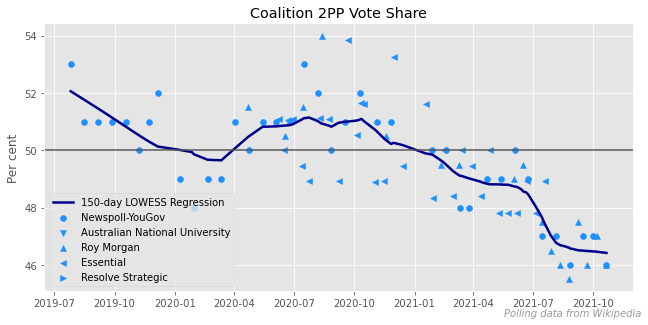

In [17]:
# Plot data points and regression line
fig, ax = plot_data_points(tpp, ('2pp vote', 'L/NP'), 'dodgerblue')
lowess, period = get_lowess(tpp[('2pp vote', 'L/NP')], tpp['Mean Date'])
ax.plot(lowess.index, lowess, c='darkblue', lw=2.5,
        label=f'{period}-day LOWESS Regression')

ax.axhline(50, c="#555555", lw=1.5)

title = 'Coalition 2PP Vote Share'
ax.set_title(title)
ax.set_xlabel(None)
ax.set_ylabel('Per cent')
ax.legend(loc='lower left', )
fig.tight_layout(pad=1.1)
fig.text(0.995, 0.005, SOURCE, ha='right', va='bottom', 
         c='#999999', style='italic')

fig.savefig(CHART_DIR+title+'.png', dpi=300)
plt.show()
plt.close()

### Primary votes

In [30]:
primaries = {
    'Coalition': [['L/NP'], 'dodgerblue', 'darkblue'],
    'Labor': [['ALP'], '#dd0000', 'darkred'],
    'Green': [['GRN'], 'green', 'darkgreen'],
    'Other': [['ONP', 'OTH'], 'orange', 'darkorange'],
}

In [31]:
def get_primary_data(pv, party, cols):
    data = pv[pv.columns[pv.columns.get_level_values(0) == 'Primary vote']].copy()
    data.columns = data.columns.droplevel(0)
    data = data[cols].sum(axis=1, skipna=True)
    data.name = party
    data = data[data > 0] # ignore NaNs mapped to zero
    
    returnable = pv[pv.columns[pv.columns.get_level_values(0).isin(['Brand', 'Mean Date'])]].copy()
    returnable[party] = data
    
    return returnable
    

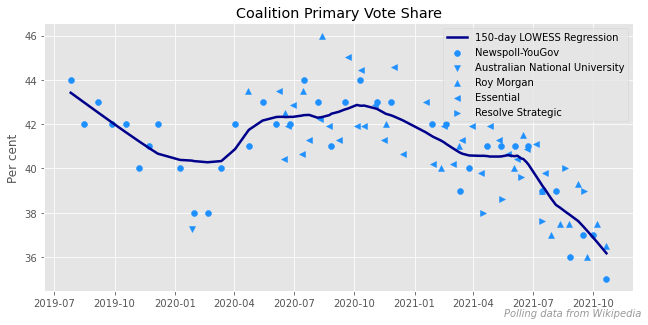

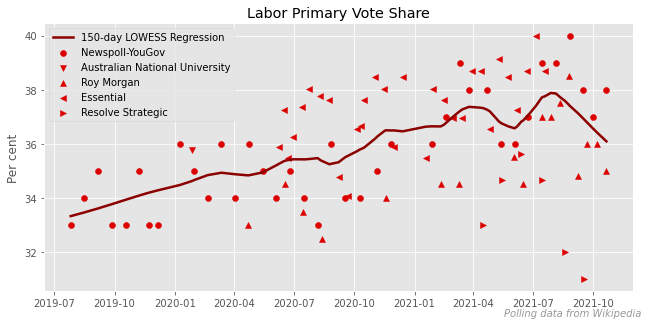

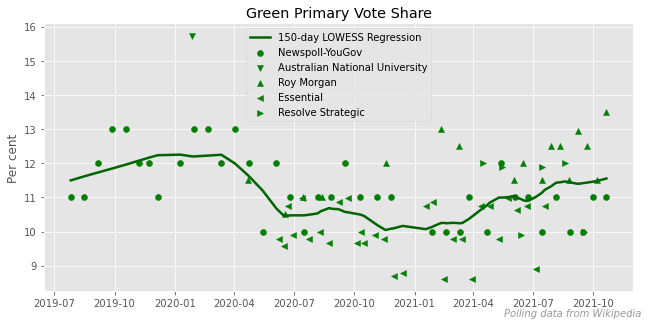

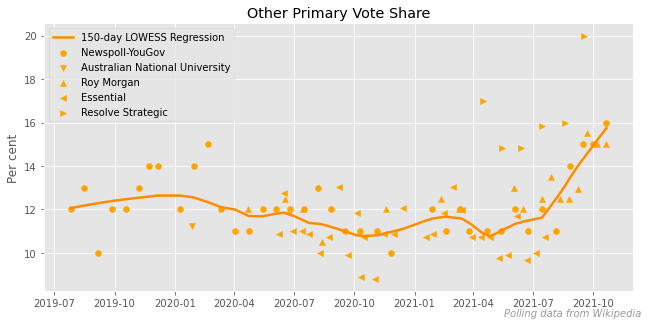

In [32]:
for party, (cols, point_c, line_c) in primaries.items():
    
    df = get_primary_data(pv, party, cols)
    fig, ax = plot_data_points(df=df, 
                               column=party, 
                               color=point_c)
    lowess, period = get_lowess(df[party], df['Mean Date'])
    ax.plot(lowess.index, lowess, c=line_c, lw=2.5,
            label=f'{period}-day LOWESS Regression')


    title = f'{party} Primary Vote Share'
    ax.set_title(title)
    ax.set_xlabel(None)
    ax.set_ylabel('Per cent')
    ax.legend(loc='best', )
    fig.tight_layout(pad=1.1)
    fig.text(0.995, 0.005, SOURCE, ha='right', va='bottom', 
             c='#999999', style='italic')

    fig.savefig(CHART_DIR+title+'.png', dpi=300)
    plt.show()
    plt.close()